# Imports

In [168]:
import cv2
import torch
import torchvision as tv
import numpy as np
import pandas as pd
# import polars as pl
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import ast
import os
import ultralytics
from ultralytics import YOLO
import PIL
import tqdm
import shutil
import paddleocr
from PIL import Image
from matplotlib.image import imread
import imutils
import math

# Вспом. функции

Данные функции являются вспомогательными для подготовки датасетов и со стороны оптимизации требуют доработки, если понадобится их использовать больше одного раза.

Парс названий файлов 1 датасета для извлечения реального значения, тк в .csv присутствуют опечатки и неточности. Пример: файлы с окончанием на _0 не имеют на изображении части после запятой, как и самой запятой.

In [ ]:
def parce_photo_name(x):
    counter = 0
    dec = ''
    fl = ''
    for sym in x:
        if sym == '_' or sym == '.':
            counter += 1
            continue
        if counter == 3:
            dec += sym
        if counter == 4:
            fl += sym
    true_dec = '00000'
    true_fl = '000'
    if len(fl) == 1:
        return true_dec[:len(true_dec) - len(dec)] + dec
    return true_dec[:len(true_dec) - len(dec)] + dec + '.' + fl + true_fl[len(fl):]

Парс словаря с координатами

In [ ]:
def parce_dict(x):
    return ast.literal_eval(x)
def ro(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
def find_top_unique(d):
    first = d[-1]
    i = 1
    while True:
        if (d[-1 - i][1] not in first[-2:]) and (d[-1 - i][2] not in first[-2:]):
            return [first, d[- 1 - i]]
        i += 1

Функция для копирования фотографий из одной папки в другую. Нужна была при кропе изображений.

In [ ]:
def copy_image_simple(source_path, destination_path):
    """Копирует изображение (простой вариант).

    Args:
        source_path: Путь к исходному изображению.
        destination_path: Путь к целевой папке.
    """
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)

    try:
        shutil.copy(source_path, destination_path)
        pass
        # print(f"Изображение скопировано из '{source_path}' в '{destination_path}'")
    except FileNotFoundError:
        pass
        # print(f"Ошибка: Файл '{source_path}' не найден.")
    except Exception as e:
        pass
        # print(f"Ошибка при копировании: {e}")

In [ ]:
# def get_image_data(name = None):
#     if name == None:
#         name = data.sample(1).photo_name.item()
#     image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
#     # mask = bgr2rgb(cv2.imread(dir + 'masks/' + name))
#     # collage = bgr2rgb(cv2.imread(dir + 'collage/' + name))
#     return  image

# Модели

## 1. Модель, которая предсказывает угол поворота
 (можно доработать, чтобы была составляющая детекции, распознавания и распознавания угла, я заинферила только часть с углом, потому что мне интересна была именно она)

In [79]:
dir_angle_model = '/Users/mori/Desktop/cv_project/'

In [82]:
ocr_angle = paddleocr.PaddleOCR(det_pse_box_thresh=0.1,
                                det_east_score_thresh=0.1,
                                det_db_box_thresh=0.1,
                                det_db_thresh=0.1,
                                use_angle_cls=True,
                                cls_model_dir=os.path.join(dir_angle_model, "ch_ppocr_mobile_v2.0_cls_infer/inference"),
                                cls_yaml_path = os.path.join(dir_angle_model, "ch_ppocr_mobile_v2.0_cls_infer/cls_mv3.yml"),
                                cls_thresh=0.1,
                                label_list=['0', '180']) # при особой необходимости можно зафайнтюнить под большее количество углов
                                                         # 0 и 180 это значения по умолчанию дефолтной модели

download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /Users/mori/Desktop/cv_project/ch_ppocr_mobile_v2.0_cls_infer/inference/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:14<00:00, 149.48it/s]

[2025/01/15 02:47:45] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/mori/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.1, det_db_box_thresh=0.1, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.1, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.1, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/mori/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_lengt

In [78]:
# ! paddleocr --help

In [87]:
if False:
    im = '/Users/mori/Desktop/cv_project/datasets/dataset_1/images/id_8_value_1095_124.jpg'
    image = imread(im)
    result = ocr_angle.ocr(im, det=False, rec=False, cls=True)
    if result[0][0][0] == '180':
        print(f'Изображение перевернуто с вероятностью {result[0][0][1]}')
    else:
        print(f'Изображение не перевернуто с вероятностью {result[0][0][1]}')
    plt.imshow(image)
    plt.show()

## 2. YOLOv8-obb для детекции bbox(oriented bbox type)

Данная модель будет обучаться на 1-м датасете, поскольку из такого формата данных разметки легче всего извлечь bounding box. 

Сами же данные сильно аугментированные, а иногда не читаемы человеком

### 2.1. Подготовка датасета

Формат данных для обучения модели yolov8-obb:
- data.yaml файл с конфигурацией модели(расположение train, test, классы)
- папка с train
- папка с test

В папках находятся 2 папки с изображениями (images) и с аналогичными названиям изображений .txt файлы с форматом данных "class x1 y1 x2 y2 x3 y3 x4 y4", где координаты отнормированы по размерам изображений

In [91]:
dir = './datasets/dataset_1/'

In [88]:
data_updated = pd.read_csv(f'dataset_1.csv')

In [90]:
data_updated.head(2)

photo_name    value  \
0  id_53_value_595_825.jpg  595.825   
1  id_553_value_65_475.jpg   65.475   

                                            location  imsize  width  height  \
0  {'type': 'polygon', 'data': [{'x': 0.30788, 'y...    1000   1000    1333   
1  {'type': 'polygon', 'data': [{'x': 0.26133, 'y...       1   1333    1000   

   target_pct  
0     0.00736  
1     0.01745

In [92]:
data_updated.__len__()

1244

In [ ]:
if False: #False - данные уже подготовлены
    iterator = 0
    for index, row in data_updated.iterrows():
        iterator += 1
        file_name = row['photo_name']
        points = parce_dict(row['location'])['data']

        points_data = []

        for i in range(len(points)): # прошу игнорировать простоту данного алгоритма
            j = 0
            while j < i:
                points_data.append([ro(*list(points[i].values()), *list(points[j].values())), i, j])
                j += 1
        
        points_data.sort(key = lambda x:x[0]) # сортируем значения по первой координате - то есть расстоянию между точками

        top2pairs = find_top_unique(points_data[:])
        sorted_points = np.array(sorted(np.array(top2pairs)[:, -2:].flatten()), dtype=int)
    
        labels = np.array([[points[point]['x'], points[point]['y']] for point in sorted_points])

        labels = np.array(labels).flatten()

        class_label = "0"
        for x in labels:
            class_label += f" {x}"
        
        if iterator <= 300:
            file_path = os.path.join('./datasets/dataset.yolov8-obb/test/labels/', f"{file_name[:-4]}.txt")
            with open(file_path, "w") as f:
                f.write(class_label)
            source_image_path = f"/Users/mori/Desktop/cv_project/datasets/dataset_1/images/{file_name}"
            destination_folder_path = "/Users/mori/Desktop/cv_project/datasets/dataset.yolov8-obb/test/images/"
            copy_image_simple(source_image_path, destination_folder_path)
        if iterator > 300 and iterator <= 600:
            file_path = os.path.join('./datasets/dataset.yolov8-obb/val/labels/', f"{file_name[:-4]}.txt")
            with open(file_path, "w") as f:
                f.write(class_label)
            source_image_path = f"/Users/mori/Desktop/cv_project/datasets/dataset_1/images/{file_name}"   
            destination_folder_path = "/Users/mori/Desktop/cv_project/datasets/dataset.yolov8-obb/val/images/"
            copy_image_simple(source_image_path, destination_folder_path)
        if iterator > 600:
            file_path = os.path.join('./datasets/dataset.yolov8-obb/train/labels/', f"{file_name[:-4]}.txt")
            with open(file_path, "w") as f:
                f.write(class_label)
            source_image_path = f"/Users/mori/Desktop/cv_project/datasets/dataset_1/images/{file_name}"   
            destination_folder_path = "/Users/mori/Desktop/cv_project/datasets/dataset.yolov8-obb/train/images/"
            copy_image_simple(source_image_path, destination_folder_path)

### 2.2. Обучение модели

In [93]:
# model = YOLO('yolov8n-obb.pt')

In [95]:
yolo_model = YOLO('/Users/mori/Desktop/cv_project/runs/obb/train42/weights/best.pt')

In [102]:
res_yolo = yolo_model.train(model='/Users/mori/Desktop/cv_project/runs/obb/train42/weights/best.pt',
    data='./dataset.yolov8-obb/data.yaml',
    epochs=50,
    patience=5, 
    batch=16, 
    imgsz=640, 
    save=True,
    save_period=5, 
    device='mps', 
    name='retrain_42',
    pretrained='/Users/mori/Desktop/cv_project/runs/obb/train42/weights/best.pt', 
    # resume=True,
    multi_scale=True, 
    plots=True)

New https://pypi.org/project/ultralytics/8.3.61 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.49 🚀 Python-3.12.2 torch-2.4.1 MPS (Apple M1)
engine/trainer: task=obb, mode=train, model=/Users/mori/Desktop/cv_project/runs/obb/train42/weights/best.pt, data=./dataset.yolov8-obb/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=mps, workers=8, project=None, name=retrain_42, exist_ok=False, pretrained=/Users/mori/Desktop/cv_project/runs/obb/train42/weights/best.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fals

train: Scanning /Users/mori/Desktop/cv_project/datasets/dataset.yolov8-obb/train/labels.cache... 644 images, 0 backgrounds, 0 corrupt: 100%|██████████| 644/644 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/mori/Desktop/cv_project/datasets/dataset.yolov8-obb/val/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

Plotting labels to runs/obb/retrain_42/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/obb/retrain_42
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      12.5G     0.9061     0.6806      1.696          9        416: 100%|██████████| 41/41 [14:05<00:00, 20.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:17<05:23, 17.96s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:26<03:32, 12.53s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:54<05:14, 19.68s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [01:15<05:02, 20.15s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [01:27<03:59, 17.13s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [01:34<02:57, 13.66s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [01:43<02:26, 12.24s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [01:53<02:06, 11.46s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 9/19 [02:02<01:46, 10.69s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [02:13<01:36, 10.67s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [02:22<01:22, 10.30s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [02:33<01:12, 10.38s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 13/19 [02:41<00:59,  9.84s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [02:49<00:45,  9.14s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 15/19 [02:57<00:35,  8.81s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [03:05<00:25,  8.55s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [03:14<00:17,  8.68s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▍| 18/19 [03:26<00:09,  9.64s/it]

WARNING ⚠️ NMS time limit 2.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [03:39<00:00, 11.57s/it]


                   all        300        300      0.923       0.19      0.204      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      16.7G      1.014     0.7275      1.823         11        928: 100%|██████████| 41/41 [22:52<00:00, 33.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:06<02:02,  6.79s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:13<01:52,  6.61s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:25<02:29,  9.37s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [00:31<01:59,  7.98s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [00:37<01:39,  7.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:42<01:22,  6.38s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [00:48<01:14,  6.23s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [00:53<01:03,  5.78s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 9/19 [00:58<00:57,  5.72s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:02<00:47,  5.24s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [01:10<00:47,  5.97s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 13/19 [01:22<00:34,  5.74s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [01:26<00:26,  5.30s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 15/19 [01:31<00:20,  5.11s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [01:35<00:14,  4.90s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [01:40<00:09,  4.87s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:55<00:00,  6.07s/it]


                   all        300        300      0.924      0.433      0.461       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.5G     0.9393     0.6858       1.81         15        672: 100%|██████████| 41/41 [08:53<00:00, 13.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:11<03:28, 11.59s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:19<02:35,  9.13s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:04<00:34,  3.86s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:29<00:00,  4.69s/it]


                   all        300        300      0.957       0.83      0.862      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      15.9G      1.073     0.7287      1.982         13        512: 100%|██████████| 41/41 [26:44<00:00, 39.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:13<04:02, 13.48s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [01:19<02:22, 11.84s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:41<01:14,  8.33s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [01:50<01:07,  8.38s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [01:58<00:59,  8.46s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [02:17<00:15,  5.27s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [02:25<00:11,  5.89s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:47<00:00,  8.84s/it]


                   all        300        300      0.969      0.824      0.846      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50        16G      1.029     0.6991          2          7        320: 100%|██████████| 41/41 [28:55<00:00, 42.33s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:09<02:42,  9.01s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [00:36<01:24,  6.06s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:42<01:18,  6.06s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [00:48<01:14,  6.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:07<00:54,  6.06s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [01:11<00:43,  5.49s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 13/19 [01:21<00:30,  5.05s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [01:26<00:25,  5.13s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [01:40<00:09,  4.54s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:09<00:00,  6.82s/it]


                   all        300        300      0.958      0.681      0.704       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      16.2G      1.009     0.7007      1.814          5        864: 100%|██████████| 41/41 [22:55<00:00, 33.54s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:12<00:00,  6.98s/it]


                   all        300        300      0.954      0.976      0.986      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      16.2G      1.012      0.695      1.957          8        768: 100%|██████████| 41/41 [30:18<00:00, 44.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:16<00:29,  2.24s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:41<00:00,  2.16s/it]


                   all        300        300      0.967      0.973      0.979       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      16.3G     0.9503     0.6337       1.85          5        704: 100%|██████████| 41/41 [04:19<00:00,  6.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:32<00:00,  1.73s/it]


                   all        300        300      0.976      0.987      0.992      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      16.5G     0.9668     0.6577      1.799          7        512: 100%|██████████| 41/41 [03:34<00:00,  5.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [00:10<00:34,  2.32s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [00:19<00:22,  2.05s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [00:28<00:14,  2.05s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:46<00:00,  2.45s/it]


                   all        300        300      0.975      0.907      0.945      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      16.6G     0.9536     0.6488      1.728         10        960: 100%|██████████| 41/41 [04:07<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:34<00:00,  1.80s/it]


                   all        300        300      0.984      0.977      0.993      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      16.7G      0.932       0.63       1.81          5        576: 100%|██████████| 41/41 [03:46<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:41<00:00,  2.19s/it]


                   all        300        300      0.958       0.98      0.991        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      16.8G     0.9377     0.6187       1.83          4        896: 100%|██████████| 41/41 [03:53<00:00,  5.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [00:13<00:20,  1.74s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:38<00:00,  2.05s/it]


                   all        300        300      0.978      0.937      0.947      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      16.9G     0.9715     0.6424      1.801          5        960: 100%|██████████| 41/41 [03:47<00:00,  5.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:38<00:00,  2.05s/it]


                   all        300        300      0.975      0.983      0.992      0.789
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 8, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

13 epochs completed in 3.308 hours.
Optimizer stripped from runs/obb/retrain_42/weights/last.pt, 6.6MB
Optimizer stripped from runs/obb/retrain_42/weights/best.pt, 6.6MB

Validating runs/obb/retrain_42/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.12.2 torch-2.4.1 MPS (Apple M1)
YOLOv8n-obb summary (fused): 187 layers, 3,077,414 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:14<00:00,  3.91s/it]


                   all        300        300      0.976      0.987      0.992      0.822
Speed: 3.3ms preprocess, 106.4ms inference, 0.0ms loss, 44.9ms postprocess per image
Results saved to runs/obb/retrain_42


Note: можно(нужно) дообучить. Можно с аугментациями, чтобы разнообразить выборку и увеличить объем. Причина остановки: Training stopped early as no improvement observed in last 5 epochs. Причина желания продолжить: см. results.png

### 2.3. Применение модели

Уверенность 0.75 показалась наилучшей на валидационной выборке. Однако, требуется дообучение модели для повышения уверенности.

In [191]:
full_dir2 = '/Users/mori/Desktop/cv_project/datasets/dataset_1/images/id_1210_value_212_913.jpg'
pred_2 = yolo_model.predict(save=True, save_txt=True, conf=0.75, source=os.path.join(full_dir2),
                            max_det=1, project='yolo_detection')


WARNING ⚠️ NMS time limit 2.050s exceeded
image 1/1 /Users/mori/Desktop/cv_project/datasets/dataset_1/images/id_1210_value_212_913.jpg: 384x640 13077.3ms
Speed: 1111.3ms preprocess, 13077.3ms inference, 3110.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to yolo_detection/retrain_423
1 label saved to yolo_detection/retrain_423/labels


In [194]:
pred_2[0].obb

ultralytics.engine.results.OBB object with attributes:

cls: tensor([0.], device='mps:0')
conf: tensor([0.9405], device='mps:0')
data: tensor([[775.9474, 651.9561, 584.7241, 135.8816,   2.3022,   0.9405,   0.0000]], device='mps:0')
id: None
is_track: False
orig_shape: (1000, 1778)
shape: torch.Size([1, 7])
xywhr: tensor([[775.9474, 651.9561, 584.7241, 135.8816,   2.3022]], device='mps:0')
xyxy: tensor([[ 530.1023,  388.9974, 1021.7926,  914.9149]], device='mps:0')
xyxyxyxy: tensor([[[ 530.1023,  824.1528],
         [ 631.2263,  914.9149],
         [1021.7926,  479.7595],
         [ 920.6686,  388.9974]]], device='mps:0')
xyxyxyxyn: tensor([[[0.2981, 0.8242],
         [0.3550, 0.9149],
         [0.5747, 0.4798],
         [0.5178, 0.3890]]], device='mps:0')

In [145]:
full_dir = '/Users/mori/Desktop/cv_project/datasets/dataset_1/images/id_5_value_100_533.jpg'
pred_1 = yolo_model.predict(save=True, save_txt=True, conf=0.75, source=os.path.join(full_dir),
                            max_det=1, project='yolo_detection')


image 1/1 /Users/mori/Desktop/cv_project/datasets/dataset_1/images/id_5_value_100_533.jpg: 640x480 94.7ms
Speed: 6.6ms preprocess, 94.7ms inference, 26.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to yolo_detection/retrain_422
1 label saved to yolo_detection/retrain_422/labels


In [ ]:
# TODO: добавить везде project = 

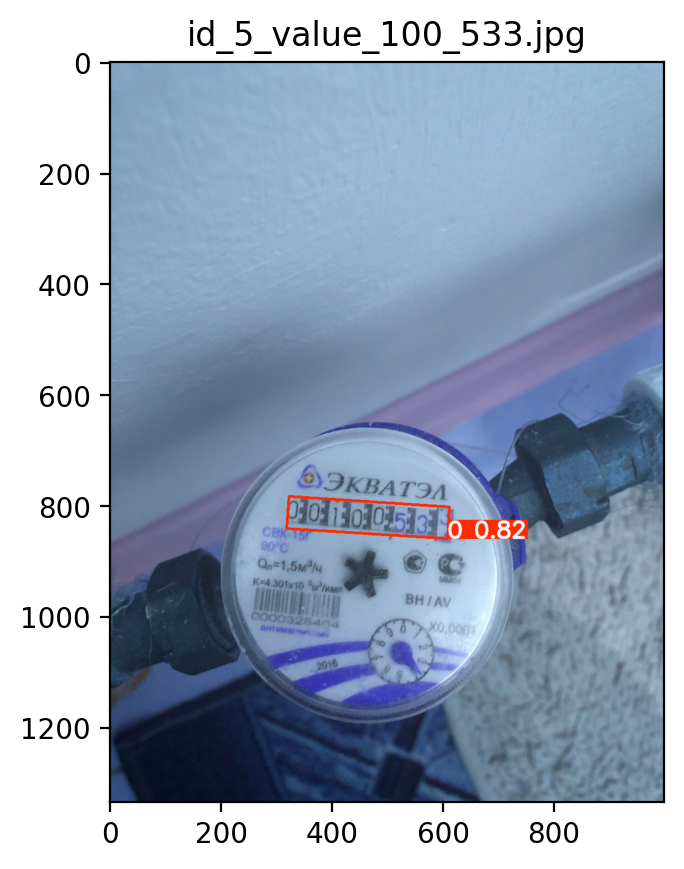

In [142]:
plt.imshow(pred_1[0].plot())
plt.title('id_5_value_100_533.jpg')
plt.show()

In [236]:
full_dir_3 = '/Users/mori/Desktop/cv_project/datasets/dataset_1/images/id_1044_value_44_311.jpg'
pred_3 = yolo_model.predict(save=True, save_txt=True, conf=0.75, source=os.path.join(full_dir_3),
                            max_det=1, project='yolo_detection')


WARNING ⚠️ NMS time limit 2.050s exceeded
image 1/1 /Users/mori/Desktop/cv_project/datasets/dataset_1/images/id_1044_value_44_311.jpg: 480x640 9369.1ms
Speed: 993.8ms preprocess, 9369.1ms inference, 2240.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to yolo_detection/retrain_424
1 label saved to yolo_detection/retrain_424/labels


In [139]:
print(f'Угол вращения: {pred_1[0].obb.xywhr[0][-1].rad2deg():.3}')

Угол вращения: 3.66


Можно предиктить сразу содержимое директории, но тогда нужно правильно отследить результаты, где получилось несколько предсказаний/ни одного
(Это реализовано)

In [ ]:
full_dir = '/Users/mori/Desktop/cv_project/datasets/dataset_1/images/id_5_value_100_533.jpg'
preds = yolo_model.predict(save=True, save_txt=True, conf=0.75, source=os.path.join(full_dir, 'images/'))

## 3. Пример разворота изображения

## 3.1. Угол

In [187]:
rotated_image = imutils.rotate(pred_1[0].plot(), angle=int(pred_1[0].obb.xywhr[0][-1].rad2deg()))
rotated_image_ = imutils.rotate(pred_1[0].orig_img, angle=int(pred_1[0].obb.xywhr[0][-1].rad2deg()))

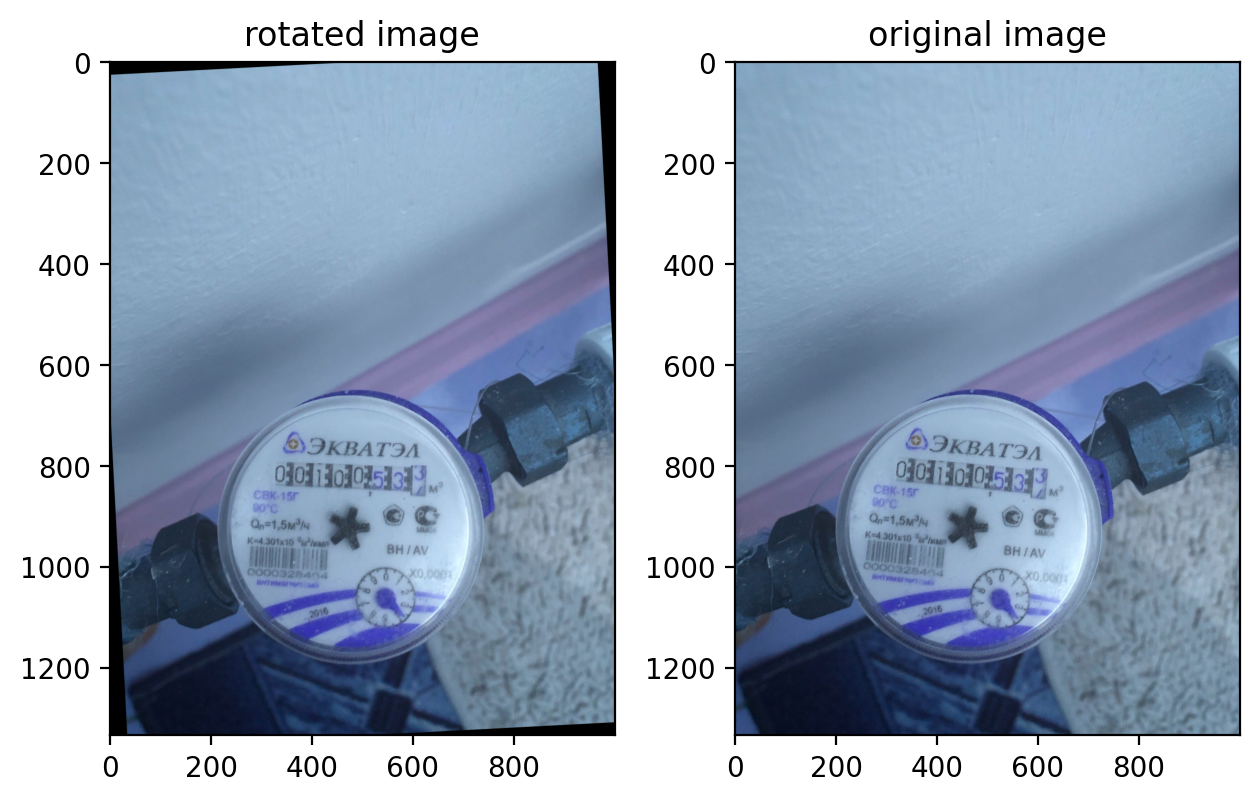

In [190]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(rotated_image_)
ax[0].set_title('rotated image')
ax[1].imshow(pred_1[0].orig_img)
ax[1].set_title('original image')
plt.tight_layout()
plt.show()

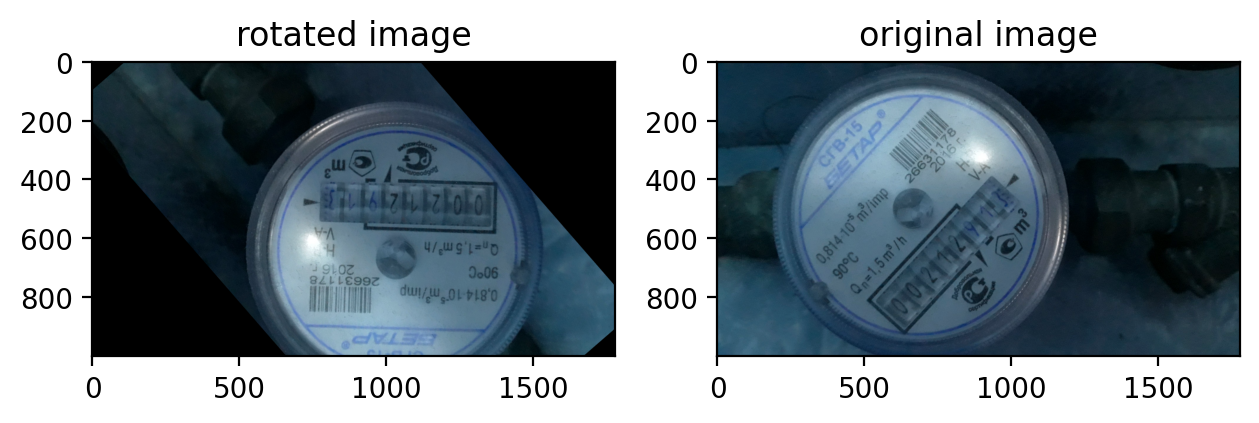

In [195]:
rotated_image_2 = imutils.rotate(pred_2[0].orig_img, angle=int(pred_2[0].obb.xywhr[0][-1].rad2deg()))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(rotated_image_2)
ax[0].set_title('rotated image')
ax[1].imshow(pred_2[0].orig_img)
ax[1].set_title('original image')
plt.tight_layout()
plt.show()

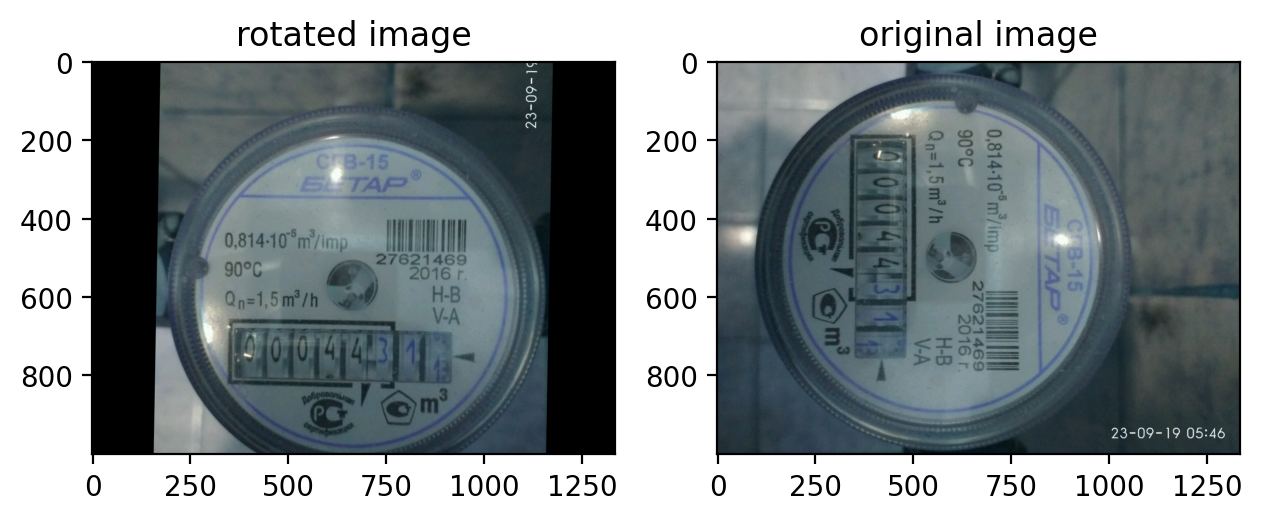

In [238]:
rotated_image_3 = imutils.rotate(pred_3[0].orig_img, angle=int(pred_3[0].obb.xywhr[0][-1].rad2deg()))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(rotated_image_3)
ax[0].set_title('rotated image')
ax[1].imshow(pred_3[0].orig_img)
ax[1].set_title('original image')
plt.tight_layout()
plt.show()

In [269]:
ocr_angle.ocr(rotated_image_3[:, :], det=False, rec=False)

[[['180', 0.90927094]]]

Проблема!!!!!!! Он считает, что изображение перевернуто. Догадка: в углу есть дата читаемым шрифтом, скорее всего моделька распознает именно эту строчку как наиболее вероятную дляидентификации поворота, требуется сделать кроп.

In [270]:
ocr_angle.ocr(rotated_image_3[200:850, :], det=False, rec=False)

[[['0', 0.63970315]]]

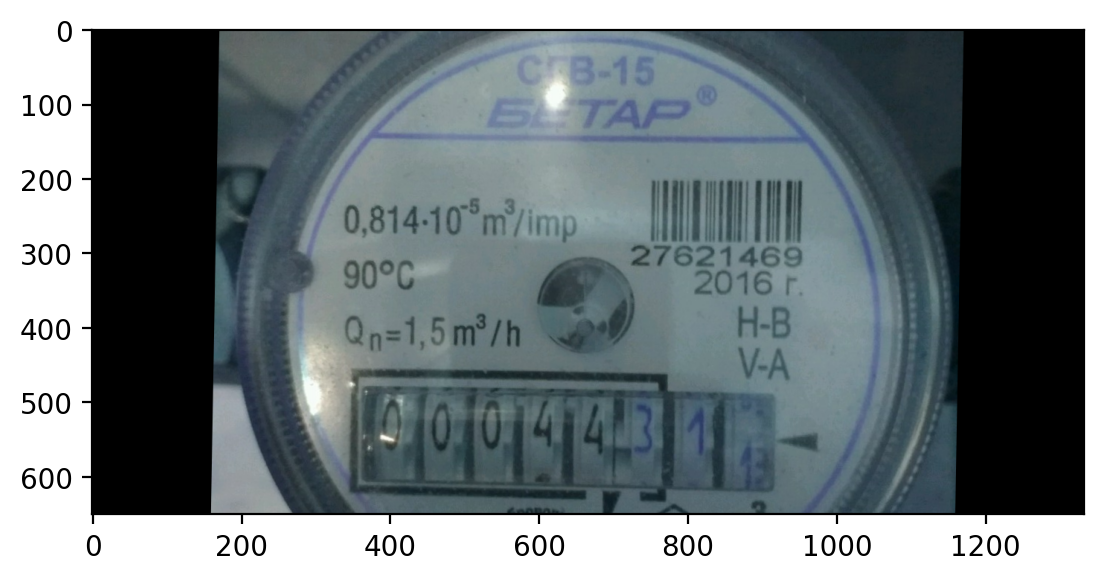

In [272]:
plt.imshow(rotated_image_3[200:850, :])
plt.show()

Похоже, догадка оказалась верной и при обрезке у нас получается правильное значене при определении ориентации текста.

In [199]:
rotated_image_2_2 = imutils.rotate(rotated_image_2, angle=180)

In [203]:
result = ocr_angle.ocr(rotated_image_2, det=False, rec=False)
result2 = ocr_angle.ocr(rotated_image_2_2, det=False, rec=False)
print(result, result2)

[[['180', 0.6433653]]] [[['0', 0.65250653]]]


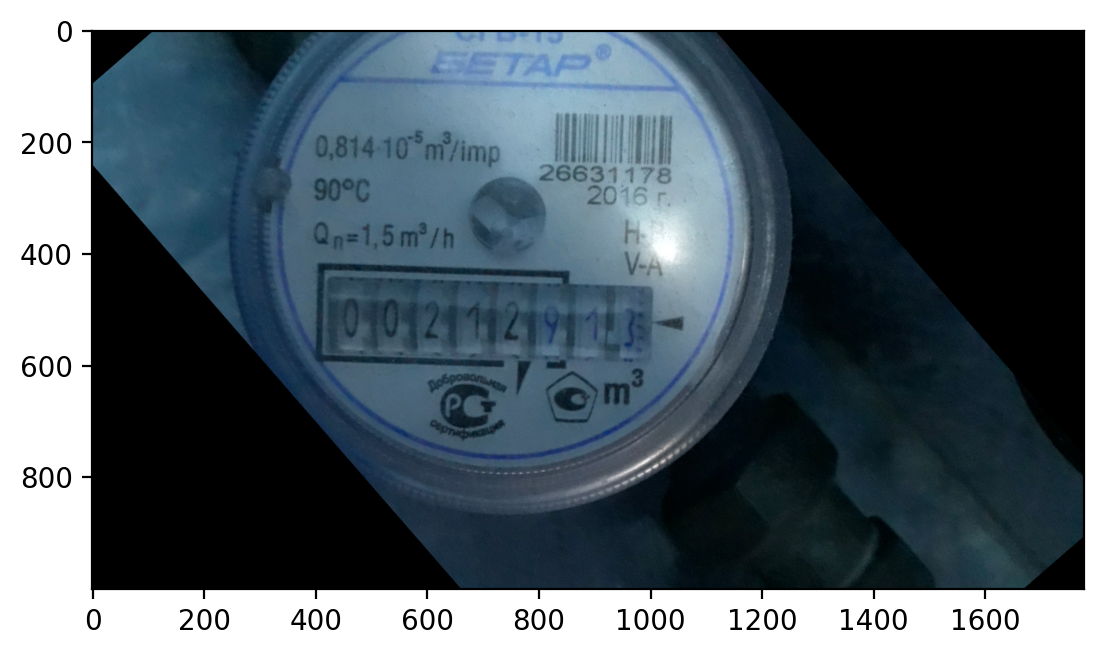

In [205]:
plt.imshow(rotated_image_2_2)
plt.show()

## 3.2. Bbox crop

In [243]:
# вычисляет 4 угла повернутого bounding box
def get_rotated_bbox_corners(center_x, center_y, width, height, rotate):
    cos_angle = np.cos(rotate)
    sin_angle = np.sin(rotate)
    
    half_width = width / 2
    half_height = height / 2
    
    # исходные координаты углов относительно центра (0, 0)
    corners = np.array([
        [-half_width, -half_height],
        [half_width, -half_height],
        [half_width, half_height],
        [-half_width, half_height]
    ], dtype=float)
    
    rotation_matrix = np.array([
        [cos_angle, -sin_angle],
        [sin_angle, cos_angle]
    ])
    
    rotated_corners = np.dot(corners, rotation_matrix.T) + np.array([center_x, center_y])
    
    return rotated_corners


def get_crop_coords(rotated_corners):
  
  min_x = int(np.min(rotated_corners[:, 0]))
  min_y = int(np.min(rotated_corners[:, 1]))
  max_x = int(np.max(rotated_corners[:, 0]))
  max_y = int(np.max(rotated_corners[:, 1]))

  return min_x, min_y, max_x, max_y

def rotate_image(image, rotation):
  
  height, width = image.shape[:2]
  center = (width / 2, height / 2)
  
  rotation_matrix = cv2.getRotationMatrix2D(center, np.rad2deg(rotation), 1.0)
  rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
  
  return rotated_image

def rotate_image_obb(obb_object):
   
   rotated_image = imutils.rotate(obb_object.plot(), 
                                  angle=int(obb_object.obb.xywhr[0][-1].rad2deg())) 
   
   return rotated_image

def crop_rotate(image, center_x, center_y, width, height, rotation, dwidth = 0):

    rotated_image = rotate_image(image, rotation)
    rotated_corners = get_rotated_bbox_corners(center_x, center_y, width + dwidth, height, rotation) #try:?
    min_x, min_y, max_x, max_y = get_crop_coords(rotated_corners)

    cropped_image = rotated_image[min_y:max_y, min_x:max_x]
    
    return cropped_image

In [257]:
def crop_rotate_obb(obb_object):
    center_x, center_y, width, height, rotate = obb_object.obb.xywhr[0].cpu().numpy()
    new_img = crop_rotate(obb_object.orig_img, center_x, center_y, width, height, rotate, width*0.2)
    return new_img

In [258]:
cropped_1 = crop_rotate_obb(pred_1[0])

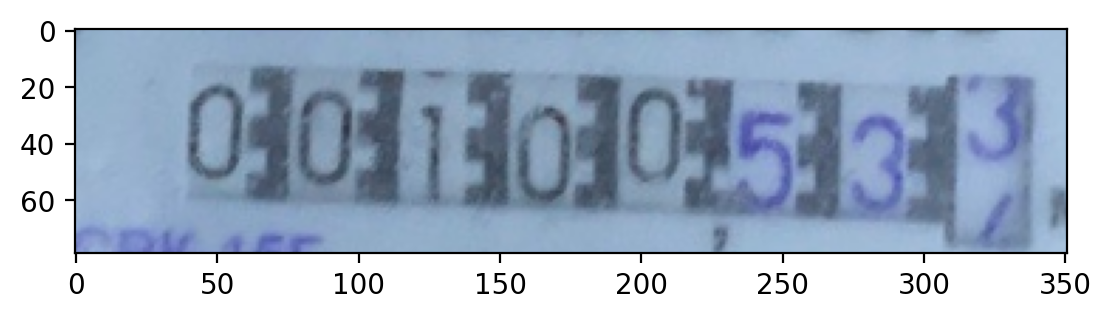

In [259]:
plt.imshow(cropped_1)
plt.show()

Цель - свести получаемые данные из yolo к такому виду для лучшей читаемости PaddleOCR

Проблема: считаны не все цифры, брать границы побольше? (Добавлено)\
Также нужно свести данные к размеру 320 на 48. Для удобства я использую адаптивный пуллинг

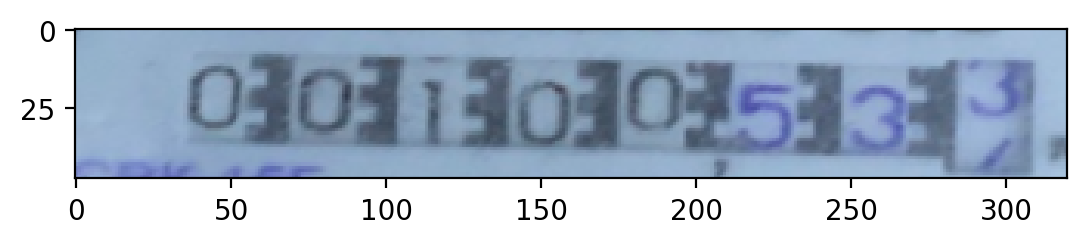

In [260]:
layer = torch.nn.AdaptiveAvgPool2d((48, 320))
t = torch.tensor(cropped_1.transpose((2, 0, 1))/255)
plt.imshow(np.array(layer(t)).transpose((1, 2, 0)))
plt.show()

In [265]:
cropped_3 = rotate_image_obb(pred_3[0])

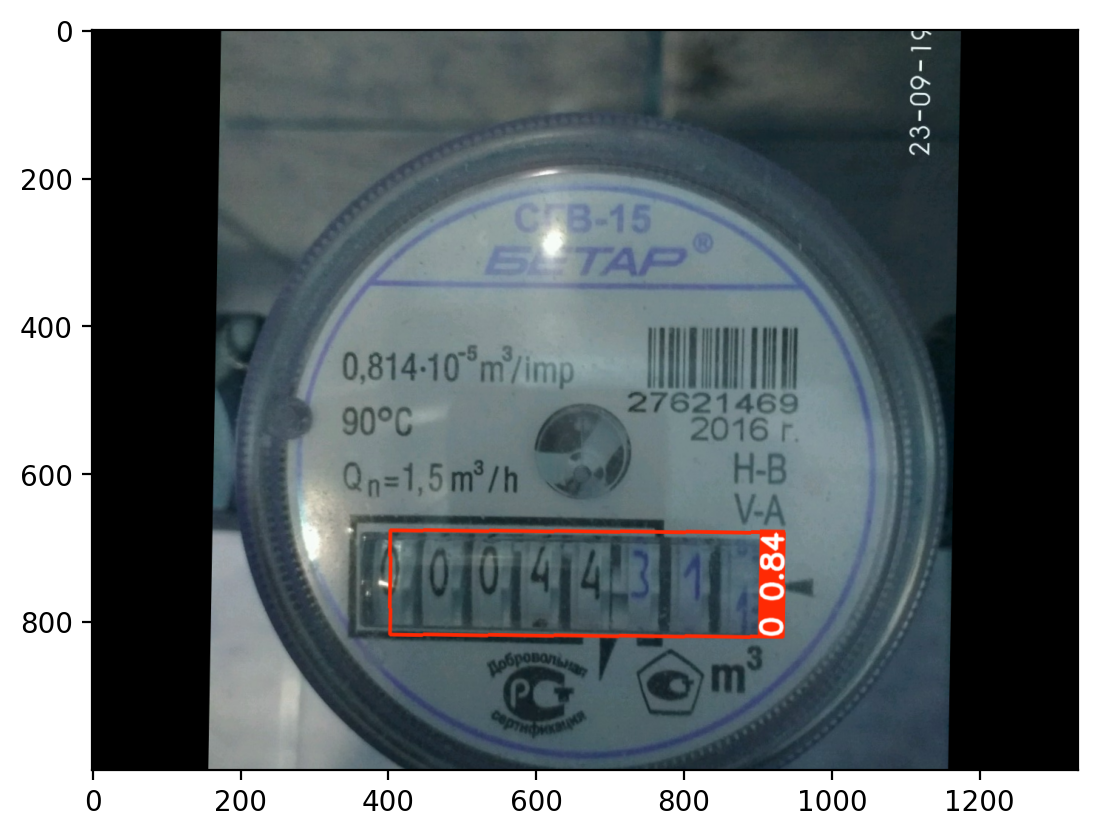

In [267]:
plt.imshow(np.array(cropped_3))
plt.show()

# 4. PaddleOCR для чтения с изображения

## 4.1. Подготовка датасета

Подготовка датасета будет состоять только в том чтобы заменить имеющиеся файлы в папках с изображениями на их обрезанные версии. 

Датасет для paddleOCR выглядит иначе, для него данные и директории были подготовлены отдельно, именно там файлы с фотографиями и будут корректироваться под поворот и кроп

Данная часть в работе, поскольку необходимо подготовить данные